In [91]:
import xarray as xr
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import faceted
from fair.forcing.ghg import meinshausen2020
import pickle
import os
import json

In [132]:
sns.set_palette('hls', 4)
sns.set_style('ticks')

plt.rcParams.update({
    "lines.markersize": 4,
    "text.usetex": True,
    "font.size": 12,
    "font.weight": 'bold',
    "text.latex.preamble": "\n".join([r'\usepackage{amsmath}', r'\usepackage{mathptmx}'])
})

fancy_titles = {
    "ssp119": "SSP1-1.9",
    "ssp126": "SSP1-2.6",
    "ssp245": "SSP2-4.5",
    "ssp370": "SSP3-7.0",
    "ssp434": "SSP4-3.4",
    "ssp460": "SSP4-6.0",
    "ssp534-over": "SSP5-3.4",
    "ssp585": "SSP5-8.5",
    "historical": "historical",
}
ar6_colors = {
    "ssp119": "#00a9cf",
    "ssp126": "#003466",
    "ssp245": "#f69320",
    "ssp370": "#df0000",
    "ssp434": "#2274ae",
    "ssp460": "#b0724e",
    "ssp534-over": "#92397a",
    "ssp585": "#980002",
    "historical": "black",
}

In [72]:
def make_kde(ZEC_div_Tze):
    kde_results = {}
    
    # Iterate over each scenario
    for scenario in ZEC_div_Tze['scenario']:
        # Extract the values for the current scenario
        data_for_scenario = ZEC_div_Tze.sel(scenario=scenario).values
        
        # Compute KDE for the current scenario
        kde = stats.gaussian_kde(data_for_scenario, bw_method="silverman")
        
        # Evaluate the KDE on the sample range
        kde_data = kde.evaluate(sample_range)
        
        # Store the result in the dictionary (or another xarray if preferred)
        kde_results[scenario.values.item()] = kde_data
    
    # Optional: If you want to convert the results to an xarray.DataArray for easier handling:
    kde_xarray = xr.DataArray(
        np.array(list(kde_results.values())), 
        coords=[list(kde_results.keys()), sample_range], 
        dims=["scenario", "sample_range"]
    )
    return kde_xarray

In [59]:
ds = xr.open_mfdataset("../../results/fair/ssp*.nc")
ds_ZEC = xr.open_mfdataset("../../results/fair/historical.nc")
ds_ZEC['scenario'] = ['historical']
ds = xr.concat([ds, ds_ZEC], dim='scenario')

In [62]:
#process SSP FaIR runs
co2_emissions_21_century = (ds.emissions.sel(specie="CO2 FFI") + ds.emissions.sel(specie="CO2 AFOLU")).sel(timepoint=slice(2000,2100)).median("config")
net_zero_times = co2_emissions_21_century.timepoint[abs(co2_emissions_21_century).argmin(dim="timepoint")] - .5
net_zero_times.values = [2059, 2077, 2100, 2100, 2100, 2100, 2068, 2100, 2024] #adjusted for scenarios that never hit net zero 
#temperature peaks
T_net_zero = ds.temperature.isel(layer=0).sel(timebound=net_zero_times)
#year when temperature peaks
#temperature at year 3000
Tf = ds.temperature.isel(layer=0, timebound=-1)

In [63]:
ZEC_div_Tze = (Tf - T_net_zero)/T_net_zero

In [73]:
sample_range = np.linspace(-1, 1, 1000)
ZEC_div_Tze_kde = make_kde(ZEC_div_Tze)

In [92]:
dirpath = os.path.realpath('../../../old_ZEC/data/')
data = dirpath + '/ZECMIP_data.json'
with open(data) as file:
    ZECMIP = json.load(file)

millenial_runs = []
for model in ZECMIP:
    if "2000" in ZECMIP[model].keys():
        if (len(ZECMIP[model]["2000"]["index"]) > 900):
            if model not in ["BERN-ecs5k", "BERN-ecs2k"]:
                millenial_runs.append(model)

# linear fit to airborne fraction for each model in ZECMIP
def airborne_fit(model):
    Af_1000 = ZECMIP[model]["1000"]['airborne'][-1]
    Af_750 = ZECMIP[model]["750"]['airborne'][-1]
    Af_2000 = ZECMIP[model]["2000"]['airborne'][-1]
    x = [750, 1000, 2000]
    y = [Af_750, Af_1000, Af_2000]
    slope, intercept, *_ = stats.linregress(x, y)
    return [slope, intercept]

fits = {}
for model in millenial_runs:
    fits[model] = airborne_fit(model)

#randomly sample the ZECMIP model linear fits 
keys = list(fits.keys())
def sample_Af(CE):
    rand_index = np.random.randint(low=0, high=len(fits))
    slope, intercept = fits[keys[rand_index]]
    return slope*CE + intercept
sample_Af_vector = np.vectorize(sample_Af)

In [76]:
def compute_final_forcing(f, Af):
                    i_timepoint = f._n_timepoints - 1 

                    GtCO2_to_ppm = f.species_configs.concentration_per_emission.sel(specie="CO2")

                    perturbed_concentrations = f.concentration.values[i_timepoint + 1 : i_timepoint + 2, ...]        
                    perturbed_CO2_concentration = f.cumulative_emissions[i_timepoint+1,..., 2]*Af*GtCO2_to_ppm + f.concentration[0,...,2]
                    perturbed_concentrations[...,2] = perturbed_CO2_concentration
    
                    perturbed_forcings = np.zeros((f._n_scenarios, f._n_configs, f._n_species))
    
                    perturbed_forcings[ ..., f._ghg_indices  
                    ] = meinshausen2020(                                                    
                        perturbed_concentrations,        
                        f.species_configs.forcing_reference_concentration.values[None, None, ...]              
                        * np.ones(                                                          
                            (1, f._n_scenarios, f._n_configs, f._n_species)        
                        ),       
                        f.species_configs.forcing_scale.values[None, None, ...]*(1 + f.species_configs["tropospheric_adjustment"].data),
                        f.species_configs.greenhouse_gas_radiative_efficiency.values[None, None, ...],         
                        f._co2_indices,                                                  
                        f._ch4_indices,                                                  
                        f._n2o_indices,                                                  
                        f._minor_ghg_indices,                                            
                    )[                                                                      
                        0:1, ..., f._ghg_indices                                         
                    ]                                                                       
                    perturbed_forcings[..., f._ghg_indices] = (perturbed_forcings[..., f._ghg_indices] - f.ghg_forcing_offset[..., f._ghg_indices])

                    perturbed_final_forcing = f.forcing[i_timepoint+1, ...]
                    perturbed_final_forcing[..., f._ghg_indices] = perturbed_forcings[..., f._ghg_indices]
                    perturbed_final_forcing = perturbed_final_forcing.sum("specie")

                    perturbed_final_forcing = perturbed_final_forcing.expand_dims({"Af":[Af]})
                    return perturbed_final_forcing

In [108]:
scenarios = fancy_titles.keys()

In [112]:
def compute_kde_for_scenarios(scenarios):
    ZEC_div_Tze_pert_kde_scenarios = {}
    sample_size = int(1e3)
    sample_range = np.linspace(-1, 1, 1000)

    for scenario in scenarios:
        with open('../../results/fair/' + scenario + ".pkl", "rb") as file:
            f = pickle.load(file)

        # Extract cumulative emissions and sample Af vectors
        CE = f.cumulative_emissions.sel(specie="CO2").isel(timebounds=-1).median("config").values * (12 / 44)
        CE = np.ones(sample_size) * CE
        Afs = sample_Af_vector(CE)

        # Compute final forcing for each Af and concatenate results
        results = [compute_final_forcing(f, x) for x in Afs]
        Ff_pert = xr.concat(results, dim="Af")

        # Compute temperature perturbation based on lambda
        lamb = f.climate_configs.ocean_heat_transfer.isel(layer=0)
        Tf_pert = Ff_pert / lamb

        # Compute ZEC/Tze based on net-zero temperature
        T_net_zero = f.temperature.isel(layer=0).sel(timebounds=net_zero_times.sel(scenario=scenario).values)
        ZEC_div_Tze_pert = (Tf_pert - T_net_zero) / T_net_zero
        ZEC_div_Tze_pert = ZEC_div_Tze_pert.values.flatten()

        # KDE computation
        ZEC_div_Tze_pert_kde = stats.gaussian_kde(ZEC_div_Tze_pert, bw_method="silverman")
        ZEC_div_Tze_pert_kde_data = ZEC_div_Tze_pert_kde.evaluate(sample_range)

        # Store the result in the dictionary for each scenario
        ZEC_div_Tze_pert_kde_scenarios[scenario] = ZEC_div_Tze_pert_kde_data

    return ZEC_div_Tze_pert_kde_scenarios

# Example usage:
kde_results = compute_kde_for_scenarios(scenarios)

In [119]:
sample_range = np.linspace(-1, 1, 1000)

In [120]:
    # Convert to xarray DataArray for structured data handling
kde_data_array = xr.DataArray(
        np.array([kde_results[sc] for sc in scenarios]),
        coords={"scenario": list(scenarios), "sample_range": sample_range},
        dims=["scenario", "sample_range"]
    )

In [ ]:
fancy_titles

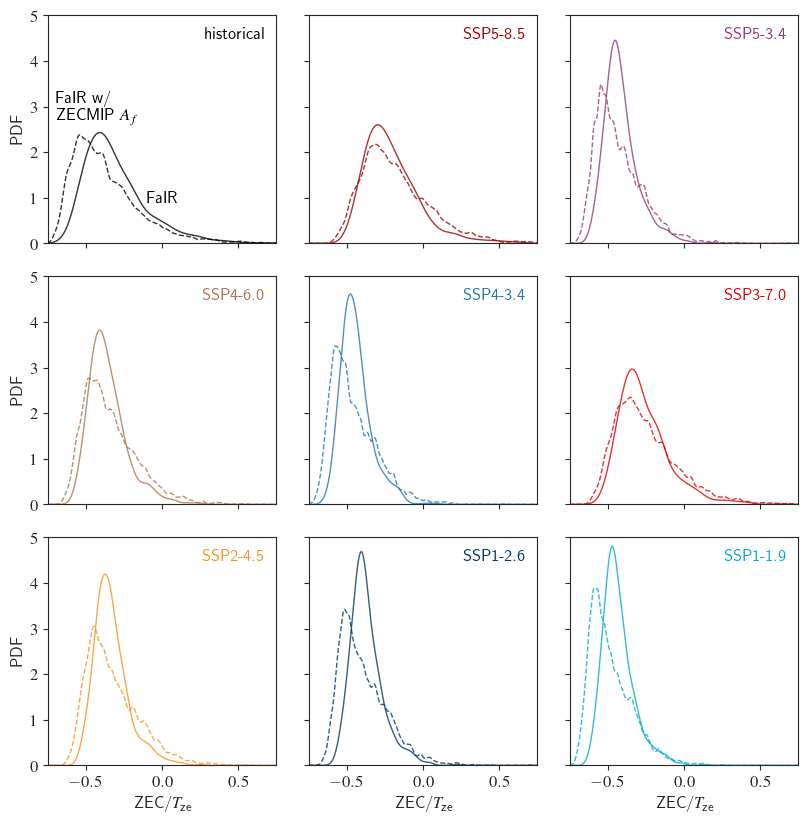

In [149]:
fig, axes = faceted.faceted(3,3, sharex=True, sharey=True, width=8, aspect=1)

linewidth = 1
for scenario, ax in zip(ZEC_div_Tze_kde.scenario[::-1], axes):
    ax.plot(sample_range, ZEC_div_Tze_kde.sel(scenario=scenario), color=ar6_colors[scenario.item()],
             linewidth=linewidth, alpha=.8)

    ax.plot(sample_range, kde_data_array.sel(scenario=scenario), color=ar6_colors[scenario.item()],
             linewidth=linewidth, alpha=.8, linestyle="dashed")

    ax.set_xlim([-.75, .75])
    ax.set_ylim([0, 5])
    ax.text(.95, .9, fancy_titles[scenario.item()], ha="right",
            transform=ax.transAxes, color=ar6_colors[scenario.item()])

axes[0].text(-.1, .9, 'FaIR', color="black", fontsize=12)
axes[0].text(-.7, 2.7, 'FaIR w/ \n ZECMIP $A_f$', color="black" , fontsize=12, ha="left")

[ax.set_xlabel(r"$\text{ZEC}/T_\text{ze}$", fontsize=12) for ax in axes[6:]]
[ax.set_ylabel(r"$\text{PDF}$", fontsize=12) for ax in axes[0::3]]

fig.savefig("/home/tarshish/Documents/research/ZEC/results/fractional_ZEC_ssps.pdf", bbox_inches="tight")